$$%
\newcommand{\BB}{{\boldsymbol B}}%
\newcommand{\cc}{{\boldsymbol c}}%
\let\dd\relax%
\newcommand{\dd}{{\boldsymbol d}}%
\newcommand{\DD}{{\boldsymbol D}}%
\newcommand{\Id}{{\boldsymbol I}}%
\newcommand{\HH}{{\boldsymbol H}}%
\newcommand{\RR}{{\boldsymbol R}}%
\newcommand{\TT}{{\boldsymbol T}}%
\newcommand{\VV}{{\boldsymbol V}}%
\newcommand{\WW}{{\boldsymbol W}}%
\newcommand{\ww}{{\boldsymbol w}}%
\newcommand{\XX}{{\boldsymbol X}}%
\renewcommand{\aa}{{\boldsymbol a}}%
\newcommand{\vv}{{\boldsymbol v}}%
\newcommand{\xx}{{\boldsymbol x}}%
\newcommand{\yy}{{\boldsymbol y}}%
% Math Symbols
\newcommand{\rrh}{{\boldsymbol \rho}}%
\newcommand{\mmu}{{\boldsymbol \mu}}%
\newcommand{\ssi}{{\boldsymbol \sigma}}%
\newcommand{\SSi}{{\boldsymbol \Sigma}}%
\newcommand{\eps}{{\boldsymbol \epsilon}}%
\newcommand{\GGa}{{\boldsymbol \Gamma}}%
\newcommand{\bz}{{\boldsymbol 0}}%
\DeclareMathOperator{\ibm}{IBM}%
\DeclareMathOperator{\car}{CAR}%
\newcommand{\N}{\mathcal N}%
\newcommand{\iid}{\stackrel{iid}{\sim}}%
\newcommand{\ud}{\, \mathrm{d}}%
\newcommand{\tmin}{t_{\mathrm{min}}}%
\newcommand{\tmax}{t_{\mathrm{max}}}%
\newcommand{\carp}{\mathrm{CAR}(p)}
$$
# rodeo: pRobabilistic ODE sOlver

*Mohan Wu, Martin Lysy*

---

## Description

**rodeo** is a Python library that uses [probabilistic numerics](http://probabilistic-numerics.org/) to solve ordinary differential equations (ODEs).  That is, most ODE solvers (such as [Euler's method](https://en.wikipedia.org/wiki/Euler_method)) produce a deterministic approximation to the ODE on a grid of size $\delta$.  As $\delta$ goes to zero, the approximation converges to the true ODE solution.  Probabilistic solvers such as **rodeo** also output a solution an a grid of size $\delta$; however, the solution is random.  Still, as $\delta$ goes to zero we get the correct answer.

**rodeo** provides a probabilistic solver for univariate process x(t) of the form

\begin{equation*}
  \WW \xx(t) = f(\xx(t), t), \qquad t \in [0, T], \quad \xx(0) = \vv,
\end{equation*}

where $\xx(t) = \big(x^{(0)}(t), x^{(1)}(t), ..., x^{(q)}(t)\big)$ consists of $x(t)$ and its first $q$ derivatives, $\WW$ is a coefficient matrix, and $f(\xx(t), t)$ is typically a nonlinear function.

**rodeo** implements the probabilistic solver of [Chkrebtii et al (2016)](https://projecteuclid.org/euclid.ba/1473276259).  This begins by putting a [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) prior on the ODE solution, and updating it sequentially as the solver steps through the grid.

## Walkthrough

### Univariate ODE

To illustrate, let's consider the following ODE example of order $q = 2$:

\begin{equation*}
x^{(2)}(t) = \sin(2t) − x^{(0)}(t), \qquad \xx_0 = (-1, 0, 1),
\end{equation*}

where the solution $x(t)$ is sought on the interval $t \in [0, 10]$.  In this case, the ODE has an analytic solution,

\begin{equation*}
x(t) = \tfrac 1 3 \big(2\sin(t) - 3\cos(t) - \sin(2t)\big).
\end{equation*}

To approximate the solution with the probabilistic solver, the Gaussian process prior we will use is a so-called [Continuous Autoregressive Process](https://CRAN.R-project.org/package=cts/vignettes/kf.pdf) of order $p$. A particularly simple $\car(p)$ proposed by [Schober](http://link.springer.com/10.1007/s11222-017-9798-7) is the $p-1$ times integrated Brownian motion, 

\begin{equation*}
\xx(t) \sim \ibm(p).
\end{equation*}

Here $\xx(t)  = (x^{(0)}(t), ..., x^{(p-1)}(t))$ consists of $x(t)$ and its first $p-1$ derivatives.
The $\ibm$ model specifies that each of $\xx(t)  = (x^{(0)}(t), ..., x^{(p-1)}(t))$ is continuous, but $x^{(p)}(t)$ is not. Therefore, we need to pick $p > q$. It's usually a good idea to have $p$ a bit larger than $q$, especially when we think that the true solution $x(t)$ is smooth. However, increasing $p$ also increases the computational burden, and doesn't necessarily have to be large for the solver to work.  For this example, we will use $p=4$. To initialize, we simply set $\xx(0) = (\xx_0, 0)$. The Python code to implement all this is as follows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad
from inference import inference

In [2]:
# RHS of ODE
from math import sin, cos
def ode_fun(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = np.zeros(1)
    x_out[0] = sin(2*t) - x[0]
    return

W = np.array([[0.0, 0.0, 1.0]])  # LHS vector of ODE
x0 = np.array([-1., 0., 1.])  # initial value for the IVP

# Time interval on which a solution is sought.
tmin = 0
tmax = 10
    
# These parameters define the order of the ODE and the CAR(p) process
n_deriv = [2]
n_deriv_prior = [4]

# zero padding
W_pad = zero_pad(W, n_deriv, n_deriv_prior)
x0_pad = zero_pad(x0, n_deriv, n_deriv_prior)

# IBM process scale factor
sigma = [.5]

n_points = 80  # number of steps in which to discretize the time interval.
dt = (tmax-tmin)/n_points  # step size

# generate the Kalman parameters corresponding to the prior
prior = ibm_init(dt, n_deriv_prior, sigma)

# instantiate the ODE solver
kalmanode = KalmanODE(W_pad, tmin, tmax, n_points, ode_fun, **prior)

# probabilistic output: draw from posterior
kalman_sim = kalmanode.solve_sim(x0_pad)

To see how well this approximation does against the exact solution, we can graph them together. First, we will define the functions of the exact solution for this example.

In [3]:
# Exact Solution for x_t^{(0)}
def ode_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

# Exact Solution for x_t^{(1)}
def ode_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

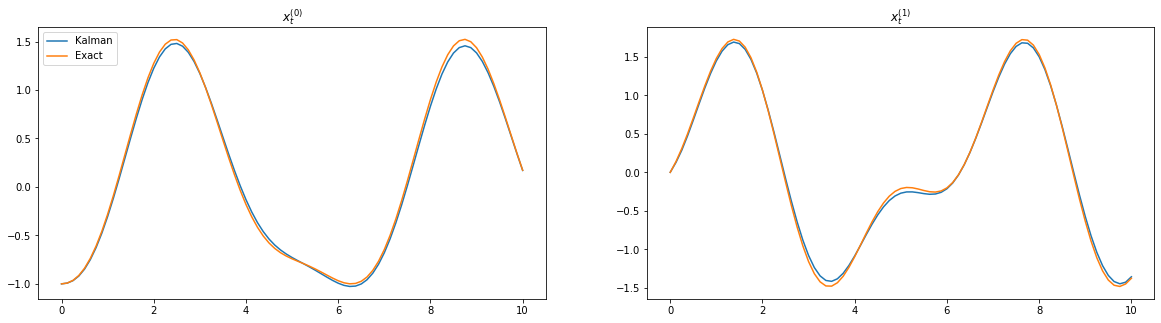

In [4]:
# Get exact solutions for x^{(0)}, x^{(1)}
tseq = np.linspace(tmin, tmax, n_points+1)
exact_x = np.zeros(n_points+1)
exact_x1 = np.zeros(n_points+1)
for t in range(n_points+1):
    exact_x[t] = ode_exact_x(tseq[t])
    exact_x1[t] = ode_exact_x1(tseq[t])

# Plot them
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, kalman_sim[:,0], label = 'Kalman')
axs[0].plot(tseq, exact_x, label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, kalman_sim[:,1], label = 'Kalman')
axs[1].plot(tseq, exact_x1, label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

### Multivariate ODE

The solver is also capable of solving multivariate ODEs. We will demonstrate with a multivariate ODE system called **Lorenz63**. This system has a chaotic regime depending on the initial values. For initial values $\vv = (-12, -5, 28)$, there is a deterministic phase which we can use to compare to the solution given by the `odeint` from `scipy`. The Lorenz equation is defined as follows:

\begin{equation}
  \begin{aligned}
    \frac{dx}{dt} &= \sigma(y - x), \\
    \frac{dy}{dt} &= x(\rho - z) - y, \\
    \frac{dz}{dt} &= xy - \beta z, \\
    \xx_0 &= (-12,-5,28).
  \end{aligned}
\end{equation}
where $(\rho, \sigma, \beta) = (28, 10, 8/3)$. To initialize $\xx(0)$ in the multivariate ODE, we simply stack the variables in a single array: $\xx(0) = (x^{(0)},..,x^{(p_1-1)}, y^{(0)},.., y^{(p_2-1)}, z^{(0)},.., z^{(p_3-1)})$. Any higher derivatives without initial values from the ODE are set to 0 as usual in a manner of zero padding.

In [9]:
# ODE function
def lorenz(X, t, theta,  out=None):
    if out is None:
        out = np.empty(3)
    rho, sigma, beta = theta
    p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[0] = -sigma*x + sigma*y
    out[1] = rho*x - y -x*z
    out[2] = -beta*z + x*y
    return out

# theta for this example
theta = np.array([28, 10, 8/3])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = [70, 125, -124/3]
X0 = np.ravel([x0, v0], 'F')

# 3.  Define the prior process

n_deriv = [1, 1, 1] # number of derivatives in IVP
n_deriv_prior = [3, 3, 3] # number of derivatives in IBM prior

# LHS Matrix of ODE
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1

# zero padding
W_pad = zero_pad(W_mat, n_deriv, n_deriv_prior)
x0_pad = zero_pad(X0, n_deriv, n_deriv_prior)

# Time interval on which a solution is sought.
tmin = 0
tmax = 20

# IBM process scale factor
sigma = np.array([.1, .1, .1])

# 4.  Instantiate the ODE solver object.

n_points = 5000 # number of steps in which to discretize the time interval.
dt = (tmax-tmin)/n_points # step size

# generate the Kalman parameters corresponding to the prior
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

# instantiate the ODE solver
ode = KalmanODE(W_pad, tmin, tmax, n_points, lorenz, **kinit)
# Run the solver to get an approximation

# 5.  Evaluate the ODE solution

# deterministic output: posterior mean
mut, Sigmat = ode.solve_mv(x0=x0_pad, theta=theta)

# probabilistic output: draw from posterior
xt = ode.solve_sim(x0=x0_pad, theta=theta)

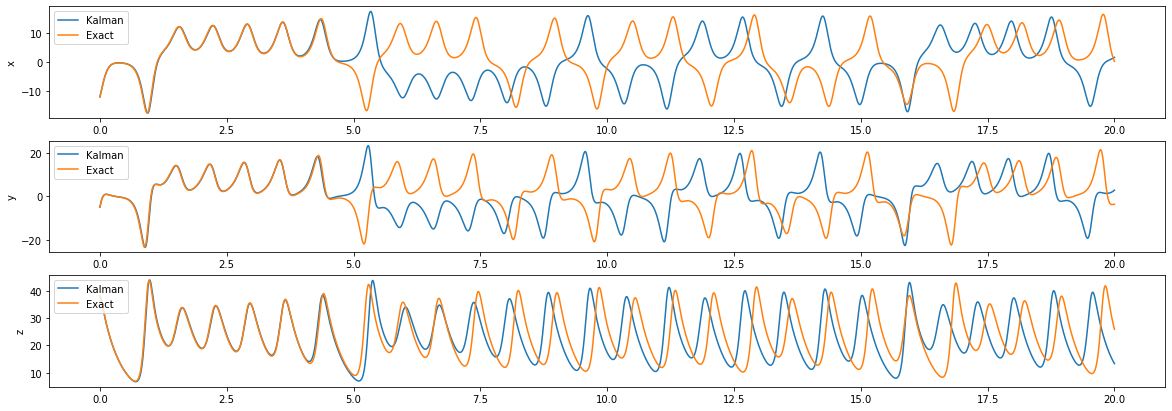

In [10]:
# Get exact solutions for the Lorenz System
tseq = np.linspace(tmin, tmax, n_points+1)
exact = odeint(lorenz, x0, tseq, args=(theta,))

# Graph the results
_, axs = plt.subplots(3, 1, figsize=(20, 7))
ylabel = ['x', 'y', 'z']
for i in range(3):
    axs[i].plot(tseq, xt[:, 3*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

### Statistical Inference

Finally, we present our solver's capability in an ODE problem involving the statistical inference of its parameters. To demonstrate we will use the famous **FitzHugh-Nagumo** model which consists of a two-state nonlinear ODE where one state describes the evolution of the neuronal membrane voltage, and the other describes the activation and deactivation of neuronal channels. Precisely, the ODE can be stated as,

\begin{equation}
  \begin{aligned}
    \frac{dV}{dt} &= c(V - \frac{V^3}{3} + R), \\
    \frac{dR}{dt} &= -\frac{(V - a - bR)}{c}, \\
    \xx_0 &= (V(0), R(0)) = (-1,1).
  \end{aligned}
\end{equation}

Suppose, we use $\theta = (a,b,c) = (.2,.2,3)$ as the true parameters with initial values $V(0) = -1$, and $R(0) = 1$. Here we set $\xx(0) = (V(0)^{(0)}, ..., V(0)^{(p-1)}, R(0)^{(0)}, ..., R(0)^{(p-1)})$ for our solver. We attempt to infer $\theta$ from the observations of both states at times $t=1,2,\ldots,40$. The priors are log-normal with the true value as the mean and unit variance. The observations are generated using the equation,

\begin{equation}
  \begin{aligned}
    Y_t = X_t + \gamma\eps_t, \quad \eps_t \iid \N(0, 1)
  \end{aligned}
\end{equation}
 
where $X_t$ are computed from `odeint` and $\gamma=0.2$ is the noise standard deviation. We have written an useful module, `inference`, to perform inference on the parameters and plot the distribution of sampled parameters. 

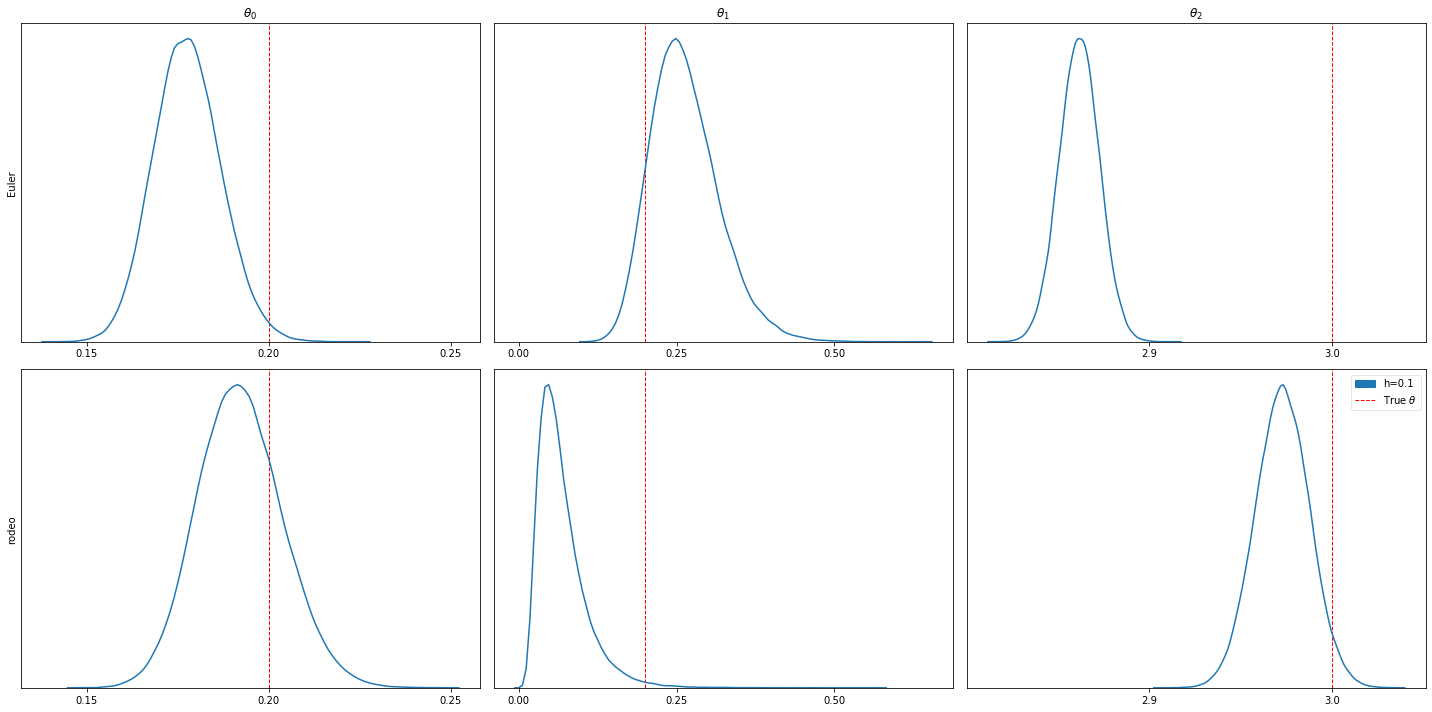

In [2]:
def fitz(X_t, t, theta, out=None):
    "FN ODE function with optional overwriting of output."
    if out is None:
        out = np.empty(2)
    a, b, c = theta
    n_deriv1 = len(X_t)//2
    V, R = X_t[0], X_t[n_deriv1]
    out[0] = c*(V - V*V*V/3 + R)
    out[1] = -1/c*(V - a + b*R)
    return out

n_deriv = [1, 1] # number of derivatives in IVP
n_deriv_prior = [3, 3] # number of derivatives in IBM prior
state_ind = [0, 3] # Index of 0th derivative of each state

# Time interval on which a solution is sought.
tmin = 0 
tmax = 40

# IBM process scale factor
sigma = [.1, .1]

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
v0 = np.array([1, 1/3])
X0 = np.ravel([x0, v0], 'F')

# pad the inputs
w_mat = np.array([[0., 1., 0., 0.], [0., 0., 0., 1.]])
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)

# logprior parameters
theta_true = np.array([0.2, 0.2, 3]) # True theta
n_theta = len(theta_true)
phi_sd = np.ones(n_theta) 

# Observation noise
gamma = 0.2

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, fitz)
Y_t = inf.simulate(fitz, x0, theta_true, gamma)

# Parameter inference using Euler's approximation
hlst = np.array([0.1])
theta_euler = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    phi_hat, phi_var = inf.phi_fit(Y_t, x0, hlst[i], theta_true, phi_sd, gamma, False)
    theta_euler[i] = inf.theta_sample(phi_hat, phi_var, n_samples)

# Parameter inference using Kalman solver
theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
for i in range(len(hlst)):
    ode_init = ibm_init(hlst[i], n_deriv_prior, sigma)
    kinit = indep_init(ode_init, n_deriv_prior)
    n_eval = int((tmax-tmin)/hlst[i])
    kode = KalmanODE(W, tmin, tmax, n_eval, fitz, **kinit)
    inf.kode = kode
    inf.W = W
    phi_hat, phi_var = inf.phi_fit(Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma, True)
    theta_kalman[i] = inf.theta_sample(phi_hat, phi_var, n_samples)

# Produces the graph in Figure 3
plot = inf.theta_plot(theta_euler, theta_kalman, theta_true, hlst)
